# Transfer learning

After an appropiate model has been developed in phase 1, the goal is to extend the previous knowledge to a second population. To do so, we aim to follow the next steps: 

1. Quantification of the domain shift
2. Modelling on phase 2 (depending on the degree of domain shift)
- 2.1. Semi-supervised learning (use of the small subset of labelled data for learning)
- 2.2. Self-supervised learning (use model of phase 1 to label the data of phase 2)
- 2.2. Unsupervised domain adaptation (align phase 1 and phase 2 distributions in a common latent space)

In [175]:
import os
import numpy as np
import pandas as pd
import importlib
import joblib

# import from custom package
from auxFuns.EDA import *
from auxFuns.modelling import *
from auxFuns.class_overlap import *

In [174]:
import auxFuns.EDA 
importlib.reload(auxFuns.EDA)

import auxFuns.modelling
importlib.reload(auxFuns.modelling)

import auxFuns.class_overlap
importlib.reload(auxFuns.class_overlap)

<module 'auxFuns.class_overlap' from 'c:\\Users\\angel\\Documents\\VSCode\\rsv_modelling_transfer_learning\\auxFuns\\class_overlap.py'>

In [129]:
# Load of the data and filter in the needed features

raw_datasets_path = os.getcwd() + '/datasets/raw'
processed_datasets_path = os.getcwd() + '/datasets/processed'

# Phase 1 data
rsv_predictors_df_v2 = pd.read_csv(processed_datasets_path + '/rsv_predictors_phase1_daysDedup_seasons_prevTest_v2.csv',low_memory=False)
rsv_predictors_phase1_df = make_it_categorical_v2(rsv_predictors_df_v2)

# Phase 2 data
rsv_phase2_df = pd.read_csv(processed_datasets_path + '/rsv_phase2_all_features.csv',low_memory=False)
rsv_phase2_df = make_it_categorical_v2(rsv_phase2_df, is_phase1 = False)

# Small subset of labelled data of phase 2:
labels_phase2_df = pd.read_csv(raw_datasets_path + '/rsv_test_phase2.csv',low_memory=False)
labels_phase2_df = labels_phase2_df.rename(columns = {'RSV_test_date':'index_date'})

# Compatibility issue detected: merging labelled and unlabelled data is challening due to incompatible date columns
rsv_phase2_df.index_date = pd.to_datetime(rsv_phase2_df.index_date)
labels_phase2_df.index_date = pd.to_datetime(labels_phase2_df.index_date)

rsv_phase2_labelled_df = labels_phase2_df.merge(rsv_phase2_df, how='left', on=['patient_id', 'index_date'])
# rsv_phase2_labelled_df = labels_phase2_df.merge(rsv_phase2_df, how='left', on=['patient_id'])
rsv_phase2_labelled_df = rsv_phase2_labelled_df.dropna()

rsv_predictors_phase1_df.shape, rsv_phase2_df.shape, rsv_phase2_labelled_df.shape

((86058, 64), (291938, 63), (2867, 64))

In [107]:
# Only 2003 of the 3073 (~65%) patients who underwent a RSV test are present in the whole populations's dataset
patient_ids_rsv_test = labels_phase2_df.patient_id.unique()
patient_ids_phase2 = rsv_phase2_df.patient_id.unique()

len(patient_ids_rsv_test), len(patient_ids_phase2), (pd.Series(patient_ids_rsv_test).isin(patient_ids_phase2)).sum()

(3073, 40507, 2003)

In [133]:
# This agrees with the results of the previous check
len(rsv_phase2_labelled_df.patient_id.unique())

1717

In [11]:
# summary_function_rsv(rsv_phase2_df, is_phase1 = False)

In [62]:
selected_features = ['sex', 'marital_status', 'race','patient_regional_location', 'age_group',
                     'Acute_upper_respiratory_infection','Influenza','Pneumonia','Bronchitis','Symptoms_and_signs__digestive_system_and_abdomen','General_symptoms_and_signs','any_symptom',
                     'COPD','AIDS','Asthma_chronic','CCI',
                     'sine','cosine','calendar_year', 
                     'healthcare_seeking', 'influenza_vaccine',
                     'n_symptoms','prev_positive_rsv','previous_test_daydiff','n_immunodeficiencies', 
                     'tumor_indicator','tumor_last_year',
                     'season',
                     'n_tests_that_day']
selected_features_v1 = ['n_tests_that_day', 'sine','cosine', 'previous_test_daydiff',
                     'Bronchitis', 'CCI',
                     'Acute_upper_respiratory_infection', 'n_immunodeficiencies', 'n_symptoms',
                     'healthcare_seeking', 
                     'General_symptoms_and_signs', 'prev_positive_rsv', 'Influenza',
                     'season','multiple_tests']
selected_features_v2 = ['n_tests_that_day', 'sine','cosine', 'previous_test_daydiff',
                     'Bronchitis', 'CCI',
                     'Acute_upper_respiratory_infection', 'n_immunodeficiencies', 'n_symptoms',
                     'healthcare_seeking', 
                     'General_symptoms_and_signs', 'prev_positive_rsv', 'Influenza',
                     'key_comorbidities','Pneumonia',
                     'season','month_of_the_test','multiple_tests',
                     'BPA','BPAI']
selected_features_v3 = selected_features_v2 + ['race', 'age_group','marital_status','sex',
                                                    'patient_regional_location','calendar_year']

selected_features_v1.append('RSV_test_result')
selected_features_v2.append('RSV_test_result')
selected_features_v3.append('RSV_test_result')

In [134]:
df_modelling_phase1 = rsv_predictors_phase1_df[selected_features_v2]
df_modelling_phase2 = rsv_phase2_labelled_df[selected_features_v2]

df_modelling_phase1.shape, df_modelling_phase2.shape

((86058, 21), (2867, 21))

In [141]:
# Let us just run the models validated in phase 1 population, and see how they perform in this 
phase1_models_path = os.getcwd() + '/models/models_phase1'

model_nonOverlapping_phase1 = joblib.load(phase1_models_path + '/nonOverlapping_rfc_8020_nofamd.joblib')
model_Overlapping_phase1 = joblib.load(phase1_models_path + '/Overlapping_rfc_8020_nofamd.joblib')

In [182]:
# As we do not know if the points fall in the overlapping or non overlapping region, we will do a soft vote for both
# A small preprocessing step needs to be implemented ad-hoc:
df_modelling_phase2.loc[:,'n_tests_that_day'] = pd.Categorical(df_modelling_phase2.n_tests_that_day, categories=[1,2])

X_test_phase2 =  pd.get_dummies(df_modelling_phase2.drop(['RSV_test_result'], axis = 1))
y_test_phase2 = df_modelling_phase2['RSV_test_result']

preds_proba_nonOverlapping = model_nonOverlapping_phase1.predict_proba(X_test_phase2)[:,1]
preds_proba_Overlapping = model_Overlapping_phase1.predict_proba(X_test_phase2)[:,1]

y_probs = (preds_proba_nonOverlapping + preds_proba_Overlapping)/2

optimal_thr_nonOverlapping = find_optimal_moving_threshold_from_probas(preds_proba_nonOverlapping, y_test = y_test_phase2)
optimal_thr_Overlapping = find_optimal_moving_threshold_from_probas(preds_proba_Overlapping, y_test = y_test_phase2)
optimal_thr_aggregated = find_optimal_moving_threshold_from_probas(y_probs = y_probs, y_test = y_test_phase2)
# the optimal threshold is found for the soft-voting approach in the aggregated part

__, __, __, __, __, __, __, __ = calculate_performance_metrics_from_probas(y_probs = y_probs, y_test = y_test_phase2, threshold = optimal_thr_aggregated, print_roc = False, print_pr = False)


Optimal threshold: 0.02
Optimal f1: 0.039999999999999994


Optimal threshold: 0.46
Optimal f1: 0.04520654715510523


Optimal threshold: 0.27
Optimal f1: 0.04788507581803671


AUC Score: 0.5273500478207405
Precision / Positive predictive value: 0.02497918401332223
Specificity: 0.5840142095914742
Recall / sensitivity: 0.5769230769230769
Negative predictive value: 0.9867947178871549
Accuracy: 0.5838855946982909
F-1: 0.04788507581803671
Precision-Recall AUC: 0.046646476037127405


**Motivation for transfer learning:** As we suspected, the model developed in phase 1 fails to generalize for phase 2 population

## 1. Quantification of the domain shift

Let us keep in mind 3 types of domain shift we may be facing:
- Covariate shift (changes in P(X))
- Label shift/prior probability shift (changes in P(y))
- Concept drift (changes in P(y|X))

Some sources (e.g. [1] classify the two first as diversity shift and the latter as correlation shift)

To gain an idea of the domain shift in our distributions, let us:

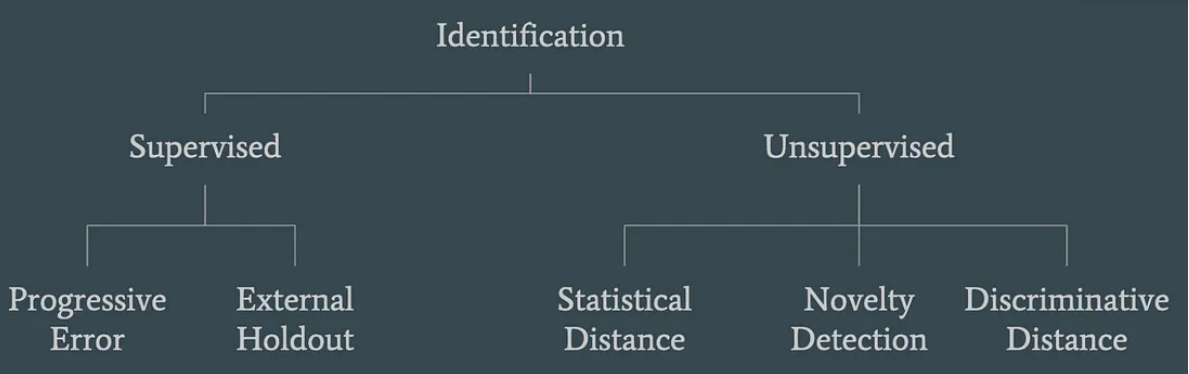

*Supervised* identification methods rely mainly on the evaluation of performance in a validation set of the new distribution of the previously developed model. As our data is mainly 

- Statistical distance (**one dimensional approach**) > histograms of values and two-sample tests.



Other methods rely on the use of alternative techniques, e.g. explainability of the model in the source population vs the out of domain (OOD) distribution [2]

[1]: Ye, Nanyang, et al. "Ood-bench: Quantifying and understanding two dimensions of out-of-distribution generalization." Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition. 2022.
[2] Mougan, C., Broelemann, K., Kasneci, G., Tiropanis, T., & Staab, S. (2022). Explanation Shift: Detecting distribution shifts on tabular data via the explanation space. arXiv preprint arXiv:2210.12369.



### 1.0: initial assessment, see how well phase 1 model performs in the labelled instances